# Torch Paper Replication
### Checking for the right torch and torchvision versions

In [3]:
try:
    import torch
    import torchvision
    assert(int(torch.__version__.split('.')[0]) >= 2 or int(torch.__version__.split(".")[1]) >= 12, "torch version must be greater than 1.12")
    assert(int(torchvision.__version__.split(".")[1]) >= 13, "torch version must be greater than 0.13")
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_109086/2401564698.py:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(int(torch.__version__.split('.')[0]) >= 2 or int(torch.__version__.split(".")[1]) >= 12, "torch version must be greater than 1.12")
/tmp/ipykernel_109086/2401564698.py:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(int(torchvision.__version__.split(".")[1]) >= 13, "torch version must be greater than 0.13")


torch version: 2.1.1+cu121
torchvision version: 0.16.1+cu121


### Importing the requried libraries

In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn 
from torchvision import transforms

from torchinfo import summary

from modular_version import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

/home/umer/umer_projects/torch_tutor/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/umer/umer_projects/torch_tutor/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Setting up the device agnostic code

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Get Data

In [6]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [7]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Create Datasets and DataLoaders
#### Prepare transforms for images

In [8]:
# Create image size (from table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


### Turn images into `DataLoader`'s

In [9]:
# BATCH_SIZE_VIT = 4096
BATCH_SIZE = 32 # this is lower than the VIT paper so as to avoid our hardware any sort of issues, as my hardware isnt that capable

# Create data loaders 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ff8c63d67d0>,
 ['pizza', 'steak', 'sushi'])

### Visualize a Single Image

In [10]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

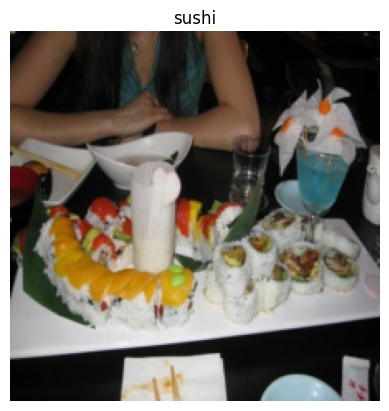

In [12]:
# Plot the image using Matplotlib
plt.imshow(image.permute(1,2,0)) # rearrange image dimensions to suit the matplotlib (H, W, Color_Channels)
plt.title(class_names[label])
plt.axis(False)

## Replicating the ViT Paper
### Inputs and outputs, layers and blocks

* Layer - takes an input, performs a function on it, returns an output.
* Block - a collection of layers, takes an input, performs a series of functions on it, returns an output.
* Architecture (or model) - a collection of blocks, takes an input, performs a series of functions on it, returns an output.